# Classifying certain music genre and others utilizing Log-likelihood Ratio and Logistic Regression

### Operationalization: 2021/2022

Below you will find the list of the imported libraries for being able to use certain functions for desired usage.

In [1]:
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import re
from sklearn import metrics

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from collections import Counter

Explanation of library usage

- pandas: this package will be used to be able to read data, visualization of the results and managing data (transforming, adding, removing etc.)
- spacy: this package will be used for pre-processing task such as tokenization and cleaning text
- numpy: for manipulating arrays
- matplotlib: to visualize data within plot
- re: for applying regex, text cleaning
- pickle: to read in the lyrics data set
- sklearn: to have access to functions to perform vectorization, splitting training data, model training, evaluation
- scipy: for applying LLR (Log-likelihood ratio) by using chi2
- collections: for counting words within a collection

# Approach

In order to answer this question, we must first understand the question posed. The producer would like to know the characteristics of a pop song. This means that we have to extract the characteristics of the pop song genre that distinguish it from other genres. Furthermore, with the result from extraction we will conclude whether the given lyrics is a classic pop or not.

To have an answer for the question we will need to follow the following steps:
- Firstly, we will clean the lyrics, to get a desired text format because we don't want e.g. punctuations to distort our analysis
- We will apply LLR to get the distinct words of pop songs and others to compare both
- We will train a logistic regression model based on the lyrics and apply class weights for the imbalanced data
- We will use the logistic regression model to predict the label for the given lyrics
- Lastly, evaluate the results gained from the model and the LLR

## Phase 1: pre-processing steps and LLR

In this phase we will apply pre-processing techniques and apply LLR

### Step 1: read data and view the structure to get a idea about the data

In [2]:
def load_dataset(data_path, path_correction):
    df = pd.read_csv(data_path)
    indx2newdate = pickle.load(open(path_correction, 'rb'))
    df['year'] = df['index'].apply(lambda x: int(indx2newdate[x][0][:4]) if indx2newdate[x][0] != '' else 0)
    return df[df.year > 1960][['song', 'year', 'artist', 'genre', 'lyrics']]

In [3]:
PATH_DF = '../data/english_cleaned_lyrics.csv' # change this to your dir
PATH_CORRECTION = '../data/indx2newdate.p' # idem

# load in the data set
df_songs = load_dataset(PATH_DF, PATH_CORRECTION)

In [4]:
# displaying the count of each genre
df_songs.genre.value_counts()

Rock          77556
Pop           23295
Metal         15671
Hip-Hop       14878
Country       10545
Electronic     5194
Jazz           5068
Indie          2489
Other          2449
R&B            2338
Folk           1373
Name: genre, dtype: int64

In [5]:
# copy the data frame so we don't modify the original data
df_copied_songs = df_songs.copy()
df_copied_songs.head()

,song,year,artist,genre,lyrics
0,ego-remix,2009,beyonce-knowles,Pop,Oh baby how you doing You know I'm gonna cut r...
5,all-i-could-do-was-cry,2008,beyonce-knowles,Pop,I heard Church bells ringing I heard A choir s...
6,once-in-a-lifetime,2008,beyonce-knowles,Pop,This is just another day that I would spend Wa...
9,why-don-t-you-love-me,2009,beyonce-knowles,Pop,N n now honey You better sit down and look aro...
16,poison,2009,beyonce-knowles,Pop,You're bad for me I clearly get it I don't see...


### Step 2: pre-processing

For better structural work for LLR and desired text format for training a model we will apply the following:
- Because Spacy will take a lot of time and require large memory due to the size of the dataset, we will have to develop a custom method for lemma and pos tagging including cleaning the text ourselves
- Custom lemma method: run spacy on all unique words within the data frame then create a word X lemma dictionary to swap each word on each row with the related lemma and fetch NOUN and ADJ.
- Lemma: I will use lemma for comparison of words and feature extraction for training purposes because it removes the inflectional endings and keeps the base form of a word. Also, because we are not interested in the style of the text but more on what makes Pop lyrics belong to Pop genre by extracting the features.
- NOUN/ ADJ: to get better indicators of words within the documents
- Regex: we only keep alphabetic characters by removing escape characters and numerical values
- Lowercase: this is commonly used according to paper: 'How we do things with words analyzing text as Social and Cultural'
- Stopword: we will use the default stopwords list from Spacy. I have chosen to remove stopwords because I don't want them to get a high probability within LLR so I can get only the relevant words.

In [22]:
# custom word lemma dictionary creator
def word_lemma_dictionary(doc_v):
    text_lemma = {}
    for doc in doc_v:
        for token in doc:
            if not token.is_punct and token.pos_ in ['NOUN', 'ADJ'] and not token.is_stop:
                text_lemma[token.text] = token.lemma_
    return text_lemma

# text cleaner and swapping word with the related lemma
def clean(v_sentence, word_lemma_dict):
    raw_split = v_sentence.split()
    new_words = []

    for word in raw_split:
        if word in word_lemma_dict and len(word) > 1:
            lemma = word_lemma_dict[word]
            new_words.append(lemma.lower())

    return new_words

# lambda func for flattening a n > 1d array
flatten = lambda t: [item for sublist in t for item in sublist]

# computes chi2 and returns llr
def compute_llr(freq_row):
    split = 2
    rr = freq_row[:split][1] / freq_row[split:][1] > freq_row[:split][0] / freq_row[split:][0]
    llr, p_value, _, _ = chi2_contingency(
        [freq_row[:split], freq_row[split:]], lambda_='log-likelihood')

    return [-llr if rr else llr, p_value]

In [15]:
# flatten and get a set of unique words from all words within the data frame
all_words = list(set(flatten(df_copied_songs.lyrics.str.split())))

In [18]:
%%time
nlp = spacy.load("en_core_web_sm")
# apply NLP on all unique words
processed_texts = [doc for doc in nlp.pipe(all_words, n_process=2, batch_size=2000, disable=["ner", "parser"])]


CPU times: user 40 s, sys: 996 ms, total: 41 s
Wall time: 1min 33s


In [19]:
%%time
# get a word X lemma dictionary of all words
all_words_dictionary = word_lemma_dictionary(processed_texts)


CPU times: user 163 ms, sys: 63.2 ms, total: 226 ms
Wall time: 225 ms


In [23]:
%%time
# clean the text and save it in a new column
df_copied_songs['clean_text'] = df_copied_songs.lyrics.apply(lambda sentence: clean(sentence, all_words_dictionary))


CPU times: user 4.38 s, sys: 64.9 ms, total: 4.44 s
Wall time: 4.44 s


In [24]:
# quick view of the data structure
df_copied_songs.head()

,song,year,artist,genre,lyrics,clean_text
0,ego-remix,2009,beyonce-knowles,Pop,Oh baby how you doing You know I'm gonna cut r...,"[baby, right, chase, woman, special, purpose, ..."
5,all-i-could-do-was-cry,2008,beyonce-knowles,Pop,I heard Church bells ringing I heard A choir s...,"[church, bell, singing, love, finger, ring, ha..."
6,once-in-a-lifetime,2008,beyonce-knowles,Pop,This is just another day that I would spend Wa...,"[day, right, night, wishin, warm, sun, dream, ..."
9,why-don-t-you-love-me,2009,beyonce-knowles,Pop,N n now honey You better sit down and look aro...,"[honey, well, yo, head, love, talk, sense, bab..."
16,poison,2009,beyonce-knowles,Pop,You're bad for me I clearly get it I don't see...,"[bad, good, death, mission, cause, bit, streng..."


### Step 3: LLR and visualize
Here we will apply LLR to extract the words that distinguish pop from the rest. First, we will create 2 subsets for comparison. Then, apply word count and frequency which we will need to compute LLR. Finally, compute the LLR and visualize the most distinguishing words of pop and other.

In [25]:
# predefine condition
condition = df_copied_songs.genre == 'Pop'

# extract 2 subsets
df_pop = df_copied_songs[condition].copy()
df_other = df_copied_songs[~condition].copy()

# get all counts except pop
word_count_other = Counter(flatten(df_other.clean_text))
freq_other = sum(word_count_other.values())

# get all counts pop
word_count_pop = Counter(flatten(df_pop.clean_text))
freq_pop = sum(word_count_pop.values())


In [26]:
# create df for pop with the counted words
df_counted_pop = pd.DataFrame.from_dict(word_count_pop, orient='index').reset_index().rename(columns={'index':'word', 0:'count_pop'})

# use word from pop to get the count in other lyrics that are not in pop subset
df_counted_pop['count_non_pop'] = df_counted_pop.word.apply(lambda word: word_count_other[word])

In [294]:
# create df for other with the counted words
df_counted_other = pd.DataFrame.from_dict(word_count_other, orient='index').reset_index().rename(columns={'index':'word', 0:'count_other'})

# use word from other to get the count in pop lyrics that are not in other subset
df_counted_other['count_pop'] = df_counted_other.word.apply(lambda word: word_count_pop[word])


In [27]:
# add all other freq word count - freq of each word count row by row
df_counted_pop['freq_all_pop'] = df_counted_pop.count_pop.apply(lambda word_count: freq_pop - word_count)
df_counted_pop['freq_all_non_pop'] = df_counted_pop.count_non_pop.apply(lambda word_count: freq_other - word_count)


In [296]:
# add all pop freq word count - freq of each word count row by row
df_counted_other['freq_all_other'] = df_counted_other.count_other.apply(lambda word_count: freq_other - word_count)
df_counted_other['freq_all_pop'] = df_counted_other.count_pop.apply(lambda word_count: freq_pop - word_count)


In [28]:
# compute the llr row by row by giving the word freq from pop and other
df_counted_pop[['llr', 'p_value']] = df_counted_pop[['count_pop', 'count_non_pop', 'freq_all_pop', 'freq_all_non_pop']].apply(lambda values: compute_llr(values), axis=1, result_type='expand')


In [298]:
# compute the llr row by row by giving the word freq from other and pop
df_counted_other[['llr', 'p_value']] = df_counted_other[['count_other', 'count_pop', 'freq_all_other', 'freq_all_pop']].apply(lambda values: compute_llr(values), axis=1, result_type='expand')


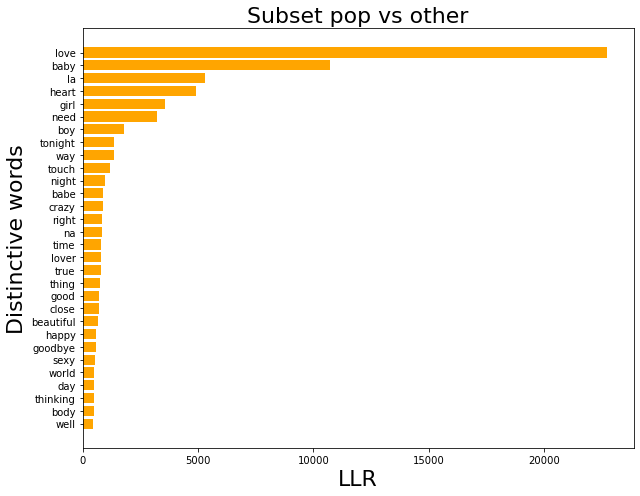

In [304]:
# visualize the results
plot_pop_vs_all = df_counted_pop[['word', 'llr']].sort_values(by='llr', ascending=False).head(30)

# define the properties to render the plot
font = {'size': 22}
fig, ax = plt.subplots(figsize=(9, 7), tight_layout=True)

y_pos = np.arange(len(plot_pop_vs_all.word))
ax.barh(y_pos, plot_pop_vs_all.llr, color='orange')
ax.set_yticks(y_pos)
ax.set_yticklabels(plot_pop_vs_all.word)
ax.invert_yaxis()
ax.set_xlabel('LLR', font)
ax.set_ylabel('Distinctive words', font)
ax.set_title('Subset pop vs other', font)

plt.show()

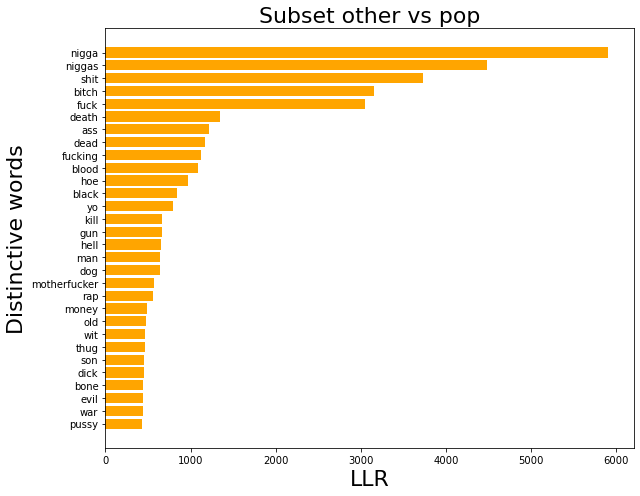

In [300]:
# visualize the results
plot_other_vs_pop = df_counted_other[['word', 'llr']].sort_values(by='llr', ascending=False).head(30)

# define the properties to render the plot
font = {'size': 22}
fig2, ax2 = plt.subplots(figsize=(9, 7), tight_layout=True)

y_pos2 = np.arange(len(plot_other_vs_pop.word))
ax2.barh(y_pos2, plot_other_vs_pop.llr, color='orange')
ax2.set_yticks(y_pos2)
ax2.set_yticklabels(plot_other_vs_pop.word)
ax2.invert_yaxis()
ax2.set_xlabel('LLR', font)
ax2.set_ylabel('Distinctive words', font)
ax2.set_title('Subset other vs pop', font)

plt.show()

## Interpretation

The plot above shows the most distinguishing words of pop compared to other (not pop). The data shows the characteristics of pop such as love, baby, heart, touch, lover, girl/boy and night. Based on this information, we can say that pop is more of a love and romantic world. Looking at the most distinctive words of Other we can clearly see that it does not fit in Pop music. However, when comparing Pop vs Other, I have to admit that the most distinctive words of Pop could also be found in Other like Country and Indie but because the predominant genres like Rock, Hip-Hop and Metal have incredibly high LLR scores they are rare. This probably doesn't answer the question, but it does give an indication of Pop's characteristics. In addition, it also offers an opportunity to perform a further analysis by applying for example a Topic Model to obtain the most prominent topics within genres.


## Phase 2: train a Logistic Regression model and evaluation

Within this phase we will train a logistic regression model by first applying model selection due to imbalanced data to overcome poor performance on the minority class. Furthermore, we will choose the best model and apply evaluation.

- firstly, we will have to encode the labels with 0 for other and 1 for pop
- then split the data into train and test
- apply vectorization (BoW), transforming to a format which the machine understands
- perform different values for class weight to handle imbalanced data
- choose best model and evaluate
- lastly, predict the label for the unseen data lyrics

### Step 1: preparing the train 70% and test 30% data
- firstly, we will have to encode the labels with 0 for other and 1 for pop
- then split the data into train and test

In [31]:
df_copied_songs['label_encode'] = df_copied_songs.genre.apply(lambda x: 1 if x == 'Pop' else 0)
df_copied_songs.label_encode.value_counts()

0    137561
1     23295
Name: label_encode, dtype: int64

In [142]:
# prepare X input and y outcome data set
X = df_copied_songs.clean_text.values.tolist()
y = df_copied_songs.label_encode.values.tolist()

# declare set labels
labels = ['other', 'pop']

# split the data in train and test set
X_train_str, X_test_str, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)


### Step 2: vectorization, class weights

- we will create a vector representation of the data by applying BOW. We dont need stopword list because that is already applied before with spacy
- we will not use TF-IDF because, e.g. the word World is common within a genre that characterizes that genre, it can lead to a reduction in characteristics
- we only want to keep words that appear in more than 5 documents because it gives importance to the genre
- we only want to keep words that occur in less then 60% of the documents so the information stays more cohesive
- we will apply class weights to the model. First we will calculate the actual needed weights for each label, then use that information together with custom weights and use it in the model selection process for selecting the best weights for the model

In [145]:
%%time

# initialize the CountVectorizer (applying BOW)
# because the texts are already tokenized and cleaned by using spacy we can skip that part in vectorization
cv = CountVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, min_df=5, max_df=0.6)

# create the vocabulary
cv.fit(X_train_str)

# transform into machine language
X_train = cv.transform(X_train_str)
X_test = cv.transform(X_test_str)


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 2.93 s, sys: 68 ms, total: 2.99 s
Wall time: 3 s


In [147]:
# to store the calculated class weights to include in the custom class weights
class_weights = {}

# get the labels and the counts of each label
grouped = df_copied_songs.label_encode.value_counts().reset_index()

# calculate and store the class weights
for category_count in grouped.values:
    #     source: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
    calculate_weight = (1 / category_count[1]) * (len(df_copied_songs) / 2.0)
    class_weights[category_count[0]] = calculate_weight

In [148]:
# print the calculated class weights
class_weights

{0: 0.5846715275405093, 1: 3.4525863919295987}

### Step 3: model selection and evaluation

- Within this step we will apply model selection to find a good balance of class weights
- From the results the best model will be selected
- Lastly, we will apply evaluation on the best model to get a view of False Positive, True Positive...

In [180]:
%%time

# stores models
models = []
# custom weights
weight_ratio_0 = [0.1, 0.2, 0.3, 0.4, 0.6, round(class_weights[0], 2)]
weight_ratio_1 = [0.9, 0.8, 0.7, 5, 8, round(class_weights[1], 2)]

# data frame for storing the reports
df_reports = pd.DataFrame()

# loops over each weight pairs
for w0, w1 in zip(weight_ratio_0, weight_ratio_1):
    
#     get weights
    weights = {0: w0, 1: w1}
    
#     initialize model
    lr = LogisticRegression(solver='lbfgs', max_iter=4000, class_weight=weights)
    
#     applying training (BoW)
    lr.fit(X_train, y_train)
    
#     store model for selection
    models.append(lr)

#     get predictions
    y_pred = lr.predict(X_test)
#     get probability
    y_prob = lr.predict_proba(X_test)

    predicted = [pred[label] for pred, label in zip(y_prob, y_test)]

#     compute AUC to summarize the precision-recall
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted, pos_label=1)
    auc_score = metrics.auc(fpr, tpr)
    
#     get classification report
    report = classification_report(y_test, y_pred, target_names=labels, output_dict=True)

    report_pop = report['pop']
    report_other = report['other']
    
    measure_keys = report_pop.keys()
    
    result_store = {}
    result_store['weights'] = weights
    result_store['auc'] = round(auc_score, 2)
    
#     store measures in data frame named df_reports
    for measure in measure_keys:
        r0 = round(report_other[measure], 3)
        r1 = round(report_pop[measure], 3)
        result_store[measure] = f'[0]: {r0}, [1]: {r1}'
        
    df_reports = df_reports.append(result_store, ignore_index=True)


CPU times: user 1min 3s, sys: 3.53 s, total: 1min 6s
Wall time: 1min 1s


<AxesSubplot:title={'center':'AUC score'}, xlabel='model number'>

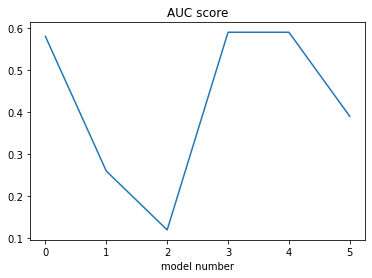

In [196]:
# plot AUC score
df_reports.auc.plot(title='AUC score', xlabel='model number')


In [181]:
df_reports

,weights,auc,precision,recall,f1-score,support
0,"{0: 0.1, 1: 0.9}",0.58,"[0]: 0.93, [1]: 0.222","[0]: 0.554, [1]: 0.754","[0]: 0.694, [1]: 0.344","[0]: 41268, [1]: 6989"
1,"{0: 0.2, 1: 0.8}",0.26,"[0]: 0.902, [1]: 0.308","[0]: 0.819, [1]: 0.476","[0]: 0.858, [1]: 0.374","[0]: 41268, [1]: 6989"
2,"{0: 0.3, 1: 0.7}",0.12,"[0]: 0.884, [1]: 0.368","[0]: 0.915, [1]: 0.291","[0]: 0.899, [1]: 0.325","[0]: 41268, [1]: 6989"
3,"{0: 0.4, 1: 5}",0.59,"[0]: 0.931, [1]: 0.211","[0]: 0.508, [1]: 0.777","[0]: 0.657, [1]: 0.332","[0]: 41268, [1]: 6989"
4,"{0: 0.6, 1: 8}",0.59,"[0]: 0.93, [1]: 0.21","[0]: 0.507, [1]: 0.775","[0]: 0.656, [1]: 0.331","[0]: 41268, [1]: 6989"
5,"{0: 0.58, 1: 3.45}",0.39,"[0]: 0.915, [1]: 0.259","[0]: 0.704, [1]: 0.612","[0]: 0.796, [1]: 0.364","[0]: 41268, [1]: 6989"


### Interpretation

According to the model selection and the report there are some interesting candidates such as model 0, 3 and 4. We will select model 3 due to a good balance between AUC score, F1-score, Recall and Precision (overall bad due to less data).

              precision    recall  f1-score   support

       other       0.93      0.51      0.66     41268
         pop       0.21      0.78      0.33      6989

    accuracy                           0.55     48257
   macro avg       0.57      0.64      0.49     48257
weighted avg       0.83      0.55      0.61     48257



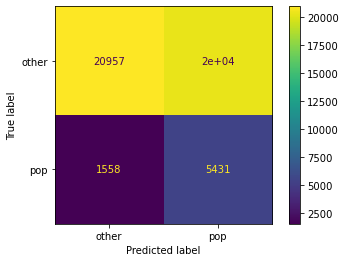

In [197]:
best_model = models[3]

# applying predicting labels
y_pred = best_model.predict(X_test)

# evaluating results
print(classification_report(y_test, y_pred, target_names=labels))

conf_matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels)

### Interpretation

- FN: 1558x missclassified, classified Other but should be Pop
- FP: 20000x missclassified, classified Pop but should be Other
- TP: The model predicted Pop 5431x correctly
- TN: The model predicted Other 20957x correctly
- Recall: the model was capable of identifying actual Pop genre for 78% correctly and Other genre for 51%
- Precision: the identifications of positive Pop genre was actually correct for 21% and for Other 93%

From the evaluation we can say that the model did not perform well due to imbalanced data even when class weights were applied. But, the model was able to classify Other correctly for 93% meaning when we give a unseen lyrics that the model will be able to correctly identify the label Other. Furthermore, from all the Pop lyrics in the data set the model found 78% of them correctly.

The next step is predicting a label for the unlabeled lyrics and evaluate the result.

### Step 4: predict the label for the unseen lyrics

- for being able to use the unseen data we will have to apply spacy, cleaning and vectorization
- then we will predict the label
- lastly, interpret the result, lyrics and the features of Pop

In [201]:
unseen_data = """The sky breaks open and the rain falls down
Oh, and the pain is blinding
But we carry on...
Seems like the end of everything
When the one you love
Turns their back on you
And the whole world falls down on you...
It's the end of the world
It's the end of the world
Well, I'm holding on...
But the world keeps dragging me down...
It's the end of the world
It's the end of the world
Well, I'm holding on...
But the world keeps dragging me down...
I got my heart on lockdown
And my eyes on the lookout
But I just know that I'm
Never gonna win this
They can keep the lights on
They can keep the music loud
I don't need anything
When I got my music
And I'm holding on...
The sky breaks open and the rain falls down
And the pain is blinding
But we carry on
(They tell you lies)
I'm holding on...
(They tell you lies)The sky breaks open and the rain falls down
Oh, and the pain is blinding
But we carry on...
Seems like the end of everything
When the one you love
Turns their back on you
And the whole world falls down on you...
It's the end of the world
It's the end of the world
Well, I'm holding on...
But the world keeps dragging me down...
It's the end of the world
It's the end of the world
Well, I'm holding on...
But the world keeps dragging me down...
I got my heart on lockdown
And my eyes on the lookout
But I just know that I'm
Never gonna win this
They can keep the lights on
They can keep the music loud
I don't need anything
When I got my music
And I'm holding on...
The sky breaks open and the rain falls down
And the pain is blinding
But we carry on
(They tell you lies)
I'm holding on...
(They tell you lies)"""

In [216]:
# clean the text from escapes
cleaned_escapes = re.sub('[\\n().]', ' ', unseen_data)

In [217]:
%%time
# apply spacy
nlp = spacy.load("en_core_web_sm")
processed_texts = [doc for doc in nlp.pipe(cleaned_escapes.split(), n_process=2, batch_size=2000, disable=["ner", "parser"])]


CPU times: user 413 ms, sys: 246 ms, total: 659 ms
Wall time: 5.13 s


In [228]:
# get the lemma nouns and adjs
unseen_dictonary = word_lemma_dictionary(processed_texts)
cleaned = clean(cleaned_escapes, unseen_dictonary)

print('Features of the given unlabeled lyrics:')
print(cleaned)

Features of the given unlabeled lyrics:
['sky', 'break', 'open', 'rain', 'pain', 'love', 'world', 'world', 'world', 'world', 'world', 'world', 'world', 'heart', 'eye', 'win', 'light', 'music', 'loud', 'need', 'music', 'sky', 'break', 'open', 'rain', 'pain', 'sky', 'break', 'open', 'rain', 'pain', 'love', 'world', 'world', 'world', 'world', 'world', 'world', 'world', 'heart', 'eye', 'win', 'light', 'music', 'loud', 'need', 'music', 'sky', 'break', 'open', 'rain', 'pain']


In [227]:
# transform into machine language
X_unseen_test = cv.transform([cleaned])

# predict the label
y_unseen_pred = best_model.predict(X_unseen_test)
y_unseen_prob = best_model.predict_proba(X_unseen_test)

# result
y_unseen_pred, y_unseen_prob

(array([1]), array([[0.13266895, 0.86733105]]))

### interpretation

From the result we can see that the model predicted the unlabeled lyrics as Pop with a probability of 86% and for Other 13%. Knowing that the model is capable of correctly identifying the label Other for 93% (Precision) then this could mean that the lyrics were actually not Other.

Next, we have to get the coefficients with the corresponding words to get a idea why a certain prediction is made, compare it with the features we extracted from LLR and the features from the unseen lyrics. Then, with this information we can come to a conclusion.


In [305]:
def get_coff_x_words(vocabulary, regression_coefficients, rows=20, asc_state=False):
    # this combines two separate lists [1, 2], ['word1', 'word2'] into one list [[1, 'word1'], [2, 'word2']]
    vocab_coef_combined = list(zip(regression_coefficients, vocabulary))
    feature_importance = pd.DataFrame(vocab_coef_combined, columns=['coef', 'word'])
    return feature_importance.sort_values('coef', ascending=asc_state).head(rows)

# get feature names
vocabulary = cv.get_feature_names_out()

# get the weights
regression_coefficients = best_model.coef_[0]

feature_importance0 = get_coff_x_words(vocabulary, regression_coefficients)

In [306]:
print('Coefficient features:')
print(feature_importance0.word.values)

Coefficient features:
['claude' 'repeater' 'punctuate' 'flair' 'agnetha' 'frankfurter'
 'sixteenth' 'stylin' 'scruffy' 'hillbilly' 'audible' 'noontime'
 'flagstaff' 'sunder' 'putter' 'ashanti' 'natal' 'socialist' 'perm'
 'curlin']


In [293]:
print('LLR Pop features:')
print(plot_pop_vs_all.word.values)

LLR Pop features:
['love' 'baby' 'la' 'heart' 'girl' 'need' 'boy' 'tonight' 'way' 'touch'
 'night' 'babe' 'crazy' 'right' 'na' 'time' 'lover' 'true' 'thing' 'good'
 'close' 'beautiful' 'happy' 'goodbye' 'sexy' 'world' 'day' 'thinking'
 'body' 'well']


In [302]:
print('LLR Other features:')
print(plot_other_vs_pop.word.values)

LLR Other features:
['nigga' 'niggas' 'shit' 'bitch' 'fuck' 'death' 'ass' 'dead' 'fucking'
 'blood' 'hoe' 'black' 'yo' 'kill' 'gun' 'hell' 'man' 'dog' 'motherfucker'
 'rap' 'money' 'old' 'wit' 'thug' 'son' 'dick' 'bone' 'evil' 'war' 'pussy']


In [276]:
print('Unseen lyrics features:')
print(set(cleaned))

Unseen lyrics features:
{'music', 'world', 'heart', 'need', 'loud', 'pain', 'win', 'rain', 'sky', 'love', 'open', 'eye', 'break', 'light'}


### Interpretation / discussion:

If we look at the result of the coefficient features and LLR pop features, we see that the coefficients are more associated with the words within the label Other than Pop. We see this by comparing both feature vectors. Pop's distinctive characters do not appear in the most commonly associated coefficient words such as Love, Baby, Girl and World. This also applies to the features of the unseen lyrics, which do not appear in the most associated coefficients. This means that the model is good at predicting the label Other, which has a higher f1 score and Precision compared to the label Pop. We can say that from the most distinctive words of Pop, number of words occur in the features of the unseen lyrics such as Need, Love and World. So, we have trained more of a model that is good at not predicting Pop and because he does not recognize patterns in unseen lyrics data to predict Other, he predicts Pop.  Because the model is not good quality knowing that the measurement scores are not very impressive, this could open a way to train a BERT model that is more suitable for finding interconnections within a space of words and contexts.

After subsetting Pop and Other data, we applied the LLR to extract the most distinctive words. Those words form a set of characters that describe Pop. Pop's characters, however, reflect that it is a genre of e.g. love, romanticism, heartbreak, farewell and happiness. When we look at the most distinctive words of Others then we can clearly see that it does not fit in Pop and the features of the unseen lyrics. But, as mentioned before, when comparing Pop vs Other the most distinctive words of Pop could also be found in Other like Country and Indie but because the predominant genres like Rock, Hip-Hop and Metal have incredibly high LLR scores they are rare. This probably doesn't answer the question, but it does give an indication of Pop's characteristics. In addition, it also offers an opportunity to perform a further analysis by applying for example a Topic Model to obtain the most prominent topics within genres.


### Data set construction:

The dataset consists of lyrics that belong to music songs from different genres over the years. Especially because we have lyrics of different genres it can be interesting exploring the characters by analyzing the words within the lyrics to gain knowledge about the differences.

### Documents consulted:

- https://scikit-learn.org/stable/index.html
- https://www.tensorflow.org/
- https://matplotlib.org/
- https://pandas.pydata.org/docs/index.html